### Kaggle Titanic Competition
After a break to finish some courses this is another intorductory competition for me. I will not be using nueral networks in this analysis.

The model at the end of this notebook achieves a score of 76.6% on the Kaggle submission. The tuned Random Forest model is clearly overfitting the training set. A previous iteration with a reduced feature set and using a Gradient Boosting Classifier achieved 79.9% accuracy on the submission file.

The notebook is included in this form as I wanted to record the full process I went through. I will now move on to a new data set as I think that will be more beneficial for training purposes than battling to increase my score on this competition.

#### Project Start
The Kaggle data has been downloaded in training and test files. Some notes on the data from Kaggle:

##### Variable Notes
Survived: Survived (1) or died (0)
Pclass: Passenger's ticket class
Name: Passenger's name
Sex: Passenger's sex
Age: Passenger's age
SibSp: Number of siblings/spouses aboard
Parch: Number of parents/children aboard
Ticket: Ticket number
Fare: Fare
Cabin: Cabin
Embarked: Port of embarkation

##### Evaluation
Predicting whether a passenger will survive or not - submission file is PassengerID and a "Survived" column with a value of 1 meaning survived

##### Hypothesis
Based on prior knowledge some key factors in determining survivial are likely to be passenger class (higher classes more likely to surive), gender (women more likely to survive) and age (children more likely to survive). Looking at other avaialable data it also seems possible that whether or not another family member survived would be relevant.

This is a binary classification problem, applicable models will be Logistic Regression, Support Vetor Machines and Decision Trees / Gradient Boosting. Supplementing these with Bagging/ Voting is likely to be beneficial.

In [22]:
#Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
sns.set_style("dark")
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import re

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, \
GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
#Import training and test files and inspect
#I will be using cross validation to develop models so will not be splitting the training data into two sets
#Take copies of training and test data frames so the originals are available unmanipulated for final processing

test = pd.read_csv('test.csv')
titan_test = test.copy()
train = pd.read_csv('train.csv')
titan_train = train.copy()

display(titan_test.head())
display(titan_train.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
""""Gather basic information on training dataset to determine preprocessing that might be needed and what features are likely
to be of use in determining survival rate.

As this is an introductory Kaggle competition I am going to assume that the training set is representative of the test set."""
display(titan_train.shape)
display(titan_train.info())
display(titan_train.describe())

display("Training set NaNs")
display(titan_train.isna().sum())
print(" ")
display("Test set NaNs")
display(titan_test.isna().sum())

(891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


'Training set NaNs'

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

'Test set NaNs'

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Initial impressions:

The Pclass column is coded as int64 but is actually categorical. In the first instance I will code it as such though it may need further processing, e.g. one hot encoding, before being used in a model.

###### Processing Action: change Pclass column to categorical

The age column is missing a lot of data but is probably useful predictively and has a high enough proportion of data avaialble that some imputation should be possible. As a working hypothesis is that whether or not a passenger is a child is important it might be as useful to be able to determine if they were under 16 or not as absolute age.

Fare has a large range and some zero values, this variable should be investigated more fully.

Sex is an object column and shold be binary encoded.

###### Processing Action: Binary encode Sex

In [4]:
#Investigate the effect of sex on survival rate.
titan_train.groupby('Sex').agg({'Survived':'mean'})

,Survived
Sex,
female,0.742038
male,0.188908


,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


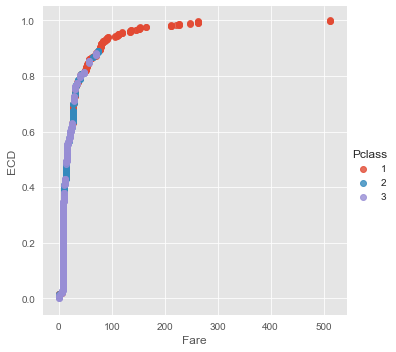

In [5]:
#Investigate effect of class on survival rate
display(titan_train.groupby('Pclass').agg({'Survived':'mean'}))

fare_cde = titan_train[['Fare','Pclass']].sort_values('Fare')
fare_cde['ECD'] = np.arange(1,len(titan_train['Fare'])+1)/len(titan_train['Fare'])

display(_ = sns.lmplot(x='Fare',y='ECD',hue='Pclass',data=fare_cde,fit_reg=False))

In [6]:
#Investigate embarkation point effect on survival rate
titan_train.groupby('Embarked').agg({'Survived':'mean'})

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


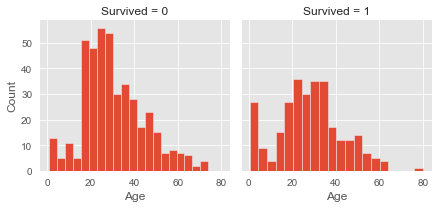

In [7]:
#Investigate the effect of age
age_hist = sns.FacetGrid(titan_train, col='Survived')
age_hist.map(plt.hist, 'Age', bins=20)
age_hist.set_ylabels('Count')

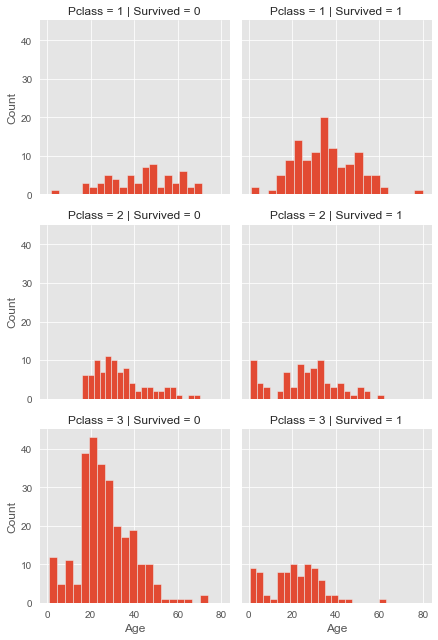

In [8]:
age_class_hist = sns.FacetGrid(titan_train,col='Survived',row='Pclass')
age_class_hist.map(plt.hist,'Age',bins=20).set_ylabels('Count')

Sex and Pclass both have a clear effect on survival probability, as does having boarded in Cherborg in particular.

###### Processing Action: Add column which is 1 if boarded in Cherborg, 0 otherwise, drop Embarked column

There is a relationship between Pclass and Fare. In the first instance I will use Fare in the analysis as being numerical rather than categorical it may bring more nuance to the model.

Under 16s (children) were more likely to have survived and the under 4s in particular. There are a number of missing ages that need to be imputed and it seems important to determine if any of the passangers with missing ages are children.

There also appears to be an effect from Pclass on the age distribution of survivors.

In [9]:
'''The age feature has a number of missing values. In the first instance under 5 and 5-15 are probably the key splits
so a solution may be to have three binary columns <16, >16 and missing. It may though be possible to infer the likely
ages of some missing values

Any passenger without an age but who is travelling with a parent is more likely than not to be under 16'''

display(sum((titan_train['Age'].isna()) & (titan_train['Parch']>=1)))
display(titan_train[(titan_train['Age'].isna()) & (titan_train['Parch']>=1)])

20

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
229,230,0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S


Using Age = NaN, Parch >1 => age <16 will reduce the number of age NaNs by 20. These can then be processed into binary encoded columns based on age <5, 5-15, 16+ and NaN. I will set the missing ages to the average age of passengers under the age of 16.

It may be possible to infer more by e.g. looking at the average Fare paid in each class by those over and under 16

###### Processing Action: If a passanger age is missing and they are travelling with a parent replace Age = NaN with Age = avg of U16 passengers
###### Processing Action: Replace Age column with Age<5, Age 5-15, Age>16 and Age=NaN, all of which are binary

In [10]:
display(titan_train.groupby('SibSp').agg({'Survived':'mean','SibSp':'count'}))
display(titan_train.groupby('Parch').agg({'Survived':'mean','Parch':'count'}))

,Survived,SibSp
SibSp,,
0,0.345395,608
1,0.535885,209
2,0.464286,28
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


,Survived,Parch
Parch,,
0,0.343658,678
1,0.550847,118
2,0.500000,80
3,0.600000,5
4,0.000000,4
5,0.200000,5
6,0.000000,1


In most cases there is an increased chance of survival if at least one relatvie is present

###### Processing Action: Create feature which is 1 if total realtvies are >=1, 0 otherwise and drop SibSp and Parch columns

15

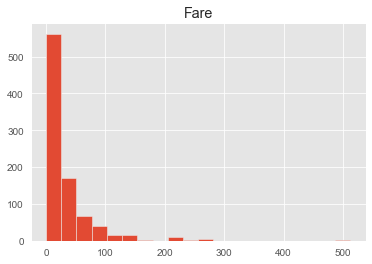

In [11]:
#Investigate Fare in more detail
titan_train.hist(column='Fare',bins=20)
titan_train['Fare'].isin([0]).sum()

In [12]:
#The majority of fares are upder $25, which was already evident from df.describe. Only 15 Fares are shown as zeros, 
#these samples should be inspected more closely to see if there is anything special about them.

#Also inspect the samples with missing embarkation points

display(titan_train.query('Fare==0'))
display(titan_train.loc[titan_train['Embarked'].isna()])

display(titan_train['Embarked'].value_counts()) #Inspect frequency of non-NaN embarkation points
display(titan_test['Embarked'].value_counts())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


S    644
C    168
Q     77
Name: Embarked, dtype: int64

S    270
C    102
Q     46
Name: Embarked, dtype: int64

The only common factors in the zero fare passengers are that they all embarked in Southampton and did not have any recorded family on board. Given the disparity in the other recorded data this does not seem particularly relevant so it seem reasonable to infer that the fare data is simply missing rather than intentionally blank. A method for estimating missing (in the case of the test set) or zero (in the training set) fare data is to use the average fare for that class of passenger.

###### Processing Action: Imput missing or zero fare data based on average fare for that class of customer 

Expiermenting with models Fare dominates the feature importance. This may be because it is the only continuous variable. I will try splitting the Fare into quartiles and creating a dummy column for each quartile.

###### Processing Action: Split Fare into quartiles and create dummy column for each quartlie

The two missing embarkation points belong to two women who shared a cabin. An internet search reveals they boarded at Southampton. As the test set does not have any missing Embarked values I will fill these in as "S" in the training set.

###### Processing Action: Replace NaNs in Embarked with "S"

Looking at the remaining columns:
PassengerId can be used as an index
Name may contain some useful information in the form of titles but will require more processing so will be left out of the initial model dataframe. Ticket contains mostly unique items so will be dropped from the data set.

In [13]:
#Developing code to binary encode Pclass feature, will be included in a further processing function later
class_dummies = pd.get_dummies(titan_train['Pclass'],prefix='class')
titan_train = pd.concat([titan_train,class_dummies],axis=1)
display(titan_train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,class_1,class_2,class_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [14]:
#Developing code to extract title from the Name feature and then binarise it. I will use regex for the practice but
#this could easily be done using .split
regex = '([A-Za-z]+)\.'
title = titan_train['Name'].str.extract(regex)
title.head()
display(title[0].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Sir           1
Ms            1
Capt          1
Don           1
Countess      1
Mme           1
Lady          1
Name: 0, dtype: int64

In [15]:
#Examine Cabin feature, due to the large number of NAs see if there is a difference in survival based on this
titan_train['Cabin'] = np.where(titan_train['Cabin'].isna(),0,1)
display(titan_train.groupby('Cabin').agg({'Survived':'mean','Cabin':'count'}))

,Survived,Cabin
Cabin,,
0,0.299854,687
1,0.666667,204


In [16]:
titan_train['Fare'] = pd.qcut(titan_train['Fare'],4,labels=False)
titan_train['Fare'].value_counts()

1    224
0    223
3    222
2    222
Name: Fare, dtype: int64

Mlle is equivalent to Miss and Mme to Mrs

###### Processing Action: replace Mlle and Mme with Miss and Mrs respectively.
###### Replace Major, Col and Capt, Lady, Countess, Don,, Dona Sir and Jonkheer with 'Bigwig'
###### Then extract titles from name column, create dummy features and drop original Name feature and created Title feature

This will increase the dimensionality of the data set but it is not so big that the computational cost will be prohibitive.

###### Processing Action: create dummy columns for Pclass feature and drop original feature

This will be done in a second processing actions function. The only change to the original function will be to delay dropping the Name column until the second processing function.

Having a cabin number is a significant predictor of survival

###### Processing Action, binary encode whether or not a passenger had a cabin


In [17]:
'''Now process the training and test data sets according to the actions set out above to remove NaNs and incorrect 
zero values before further exploratory data analysis

Categorise Pclass 
Binary encode sex (use dictionary)
Impute average for missing fares (set 0 to NaN then use groupby for mean per class) 
Replace "Embarked" NaNs with "S"
Add binary column for having boarded at Cherborg and drop Embarked
Replace NaN ages of passengers with parents with average ages of U16s and split Age column into four binaries
Add feature for relative >=1
Columns to drop: Cabin, Name, Ticket, Embarked, Age, SibSp and Parch'''

sex_dict = {'male':1,'female':0} #dictionary for binary mapping sex
avg_fare_by_class = titan_train.groupby('Pclass').agg({'Fare':'mean'}) # set up table for imputing average Fares by class
avg_age_U16 = round(titan_train[titan_train['Age']<16]['Age'].mean())

def Processing_Actions(df,name):
    '''Function to perform cleaning up of Titanic data'''
    
    df['Pclass'] = df['Pclass'].astype('category')
    print(name + " Pclass changed to categorical")
    
    df['Sex'] = df['Sex'].map(sex_dict)
    print(name + " sex mapping completed")
    
    df['Fare'].replace(0,np.nan)
    df = df.set_index('Pclass')
    df['Fare'].fillna(avg_fare_by_class['Fare'],inplace=True)
    df = df.reset_index()
    print("Number of " + name +" Fares reporting NaN is "+str(df['Fare'].isna().sum()))
    print(name + " average Fare imputed")
    
    df['Embarked'].fillna("S",inplace=True)
    print(name + " embarked NaNs replaced")
    
    df['Cherborg'] = np.where(df['Embarked']=="C",1,0)
    print(name + " Cherborg column created")
    
    idx = df.index[(df['Age'].isna()) & (df['Parch']>=1)]
    col_idx = df.columns.get_loc("Age")
    df.iloc[idx,col_idx] = avg_age_U16
    df["Under 5"] = np.where(df['Age']<5,1,0)
    df["Age 5-15"] = np.where(df['Age']<16, 1, 0)
    df["16+"] = np.where(df['Age']>=16,1,0)
    df['Age_Missing'] = np.where(df['Age'].isna(),1,0)
    print(name + " binary age columns created")

    df['Relatives'] = df['SibSp'] + df['Parch']
    df['Relatives'] = np.where(df['Relatives'] >=1,1,0)
    print(name + ' Relatives column created')
    
    class_dummies = pd.get_dummies(df['Pclass'],prefix='Class')
    df = pd.concat([df,class_dummies],axis=1)
    print(name + ' Pclass binary encoded')
    
    regex = '([A-Za-z]+)\.'
    df['Title'] = df['Name'].str.extract(regex)
    df['Title'] = df['Title'].replace({'Mlle':'Miss','Mme':'Mrs'})
    df['Title'] = df['Title'].replace(['Major','Col','Capt','Lady','Countess','Don','Sir','Jonkheer','Dona'],'Bigwig')
    name_dummies = pd.get_dummies(df['Title'],prefix='Title')
    df = pd.concat([df,name_dummies],axis=1)
    df.drop(['Title'],axis=1)
    print(name + ' Titles extrated')
    
    df['Cabin'] = np.where(df['Cabin'].isna(),0,1)
    print(name + ' Cabin binary encoded')
    
    df['Fare'] = pd.qcut(df['Fare'],4, labels = False)
    df['Fare'] = df['Fare'] + 1
    fare_dummies = pd.get_dummies(df['Fare'],prefix='Fare_Quartile')
    df = pd.concat([df,fare_dummies],axis=1)
    print(name + ' Fare split into quartiles and dummies created')
        
    df.drop(['Ticket','Embarked', 'Age','SibSp','Parch','Name','Pclass','Fare','Title'],axis=1,inplace=True)
    print(name + " dropping columns completed")
     
    display(df.head())
    print(" ")
    
    return df

titan_train_proc = Processing_Actions(train,"Train")
titan_test_proc = Processing_Actions(test,"Test")
    

Train Pclass changed to categorical
Train sex mapping completed
Number of Train Fares reporting NaN is 0
Train average Fare imputed
Train embarked NaNs replaced
Train Cherborg column created
Train binary age columns created
Train Relatives column created
Train Pclass binary encoded
Train Titles extrated
Train Cabin binary encoded
Train Fare split into quartiles and dummies created
Train dropping columns completed


,PassengerId,Survived,Sex,Cabin,Cherborg,Under 5,Age 5-15,16+,Age_Missing,Relatives,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Fare_Quartile_1,Fare_Quartile_2,Fare_Quartile_3,Fare_Quartile_4
0,1,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
1,2,1,0,1,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
2,3,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,4,1,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
4,5,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


 
Test Pclass changed to categorical
Test sex mapping completed
Number of Test Fares reporting NaN is 0
Test average Fare imputed
Test embarked NaNs replaced
Test Cherborg column created
Test binary age columns created
Test Relatives column created
Test Pclass binary encoded
Test Titles extrated
Test Cabin binary encoded
Test Fare split into quartiles and dummies created
Test dropping columns completed


,PassengerId,Sex,Cabin,Cherborg,Under 5,Age 5-15,16+,Age_Missing,Relatives,Class_1,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Fare_Quartile_1,Fare_Quartile_2,Fare_Quartile_3,Fare_Quartile_4
0,892,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,893,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,894,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,895,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,896,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [18]:
#Baseline predictor - as the majority of people died a baseline accuracy can be obtained through a model which predicts
#every passenger dies. The first point of any ML model is to beat this level

baseline_pred = np.zeros(len(titan_train['Survived']))
baseline_accuracy = accuracy_score(titan_train['Survived'],baseline_pred)
print("Basline accuracy is {:.2f}%".format(baseline_accuracy*100))

Basline accuracy is 61.62%


In [19]:
#Now implement some ML models with default settings using 5-fold CV
features = titan_train_proc.drop(['Survived','PassengerId'],axis=1)
target = titan_train_proc['Survived']

models = [(LogisticRegression(),'LogReg'),(RandomForestClassifier(),'RandomForest'),(SVC(),'SVC'), \
          (DecisionTreeClassifier(),'DecisionTree'),(GradientBoostingClassifier(),'GBC')]

model_comp = pd.DataFrame(columns = ['Model','CV_mean','CV_std'])

for ind, (model, name) in enumerate(models):
    cv_results = cross_val_score(model,features,target,cv=5)
    cv_mean = cv_results.mean()
    cv_std = cv_results.std()
    model_comp.loc[ind,'Model'] = name
    model_comp.loc[ind,'CV_mean'] = cv_mean
    model_comp.loc[ind,'CV_std'] = cv_std

display(model_comp.sort_values('CV_mean',ascending=False))

,Model,CV_mean,CV_std
1,RandomForest,0.815931,0.0226275
2,SVC,0.814814,0.0162877
3,DecisionTree,0.813728,0.0286804
4,GBC,0.810332,0.0198405
0,LogReg,0.798016,0.0239972


In [20]:
#All initial models are within one standard deviation of each other. Now try some bagging/ voting to see if that helps

model = DecisionTreeClassifier()
estimators = 10
ensemble = [(BaggingClassifier(base_estimator = model, n_estimators = estimators),'Bagging'),\
           (AdaBoostClassifier(base_estimator = model, n_estimators = estimators),'AdaBoost')]

for ind, (model, name) in enumerate(ensemble, start=len(models)):
    cv_results = cross_val_score(model,features,target,cv=5)
    cv_mean = cv_results.mean()
    cv_std = cv_results.std()
    model_comp.loc[ind,'Model'] = name
    model_comp.loc[ind,'CV_mean'] = cv_mean
    model_comp.loc[ind,'CV_std'] = cv_std

display(model_comp.sort_values('CV_mean',ascending=False))

,Model,CV_mean,CV_std
1,RandomForest,0.815931,0.0226275
2,SVC,0.814814,0.0162877
3,DecisionTree,0.813728,0.0286804
6,AdaBoost,0.812586,0.0207465
4,GBC,0.810332,0.0198405
5,Bagging,0.810326,0.0202174
0,LogReg,0.798016,0.0239972


On the fully processed data set most model perform very similarly to one another. Due to its interpretability I will used the Decision Tree Classifier and then Random Forest as optimised models.

0.88

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       549
           1       0.89      0.77      0.83       342

    accuracy                           0.88       891
   macro avg       0.88      0.86      0.87       891
weighted avg       0.88      0.88      0.87       891



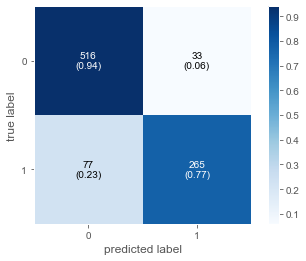

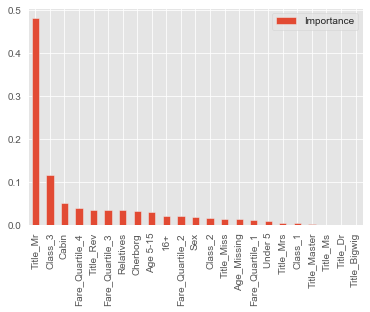

In [23]:
#First look at unoptimised decision tree on full training set
dt_clf = DecisionTreeClassifier()
dt_clf.fit(features,target)
pred = dt_clf.predict(features)

display(round(accuracy_score(target,pred),2))
print(classification_report(target,pred))
cm = confusion_matrix(target,pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,colorbar=True)
plt.show()

feature_importances = pd.DataFrame({'Importance':dt_clf.feature_importances_},index=features.columns)
display(_ = feature_importances.sort_values('Importance',ascending=False).plot(kind='bar'))

In [24]:
#Now tune the decision tree
params = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

tuned_dt = GridSearchCV(dt_clf,param_grid = params,cv=5,scoring='accuracy',n_jobs=-1)
tuned_dt.fit(features,target)
print(tuned_dt.score(features, target))
print(tuned_dt.best_params_)

0.856341189674523
{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


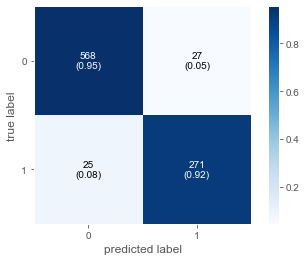

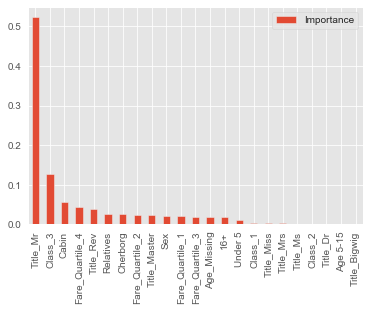

In [25]:
dt_opt = DecisionTreeClassifier(**tuned_dt.best_params_)
dt_opt.fit(features,target)
target = dt_opt.predict(features)
cm = confusion_matrix(target,pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,colorbar=True)
plt.show()

feature_importances = pd.DataFrame({'Importance':dt_opt.feature_importances_},index=features.columns)
display(_ = feature_importances.sort_values('Importance',ascending=False).plot(kind='bar'))

1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       595
           1       1.00      1.00      1.00       296

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



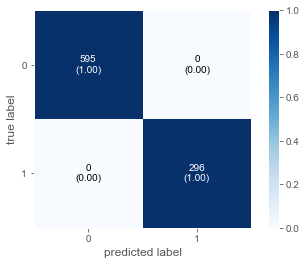

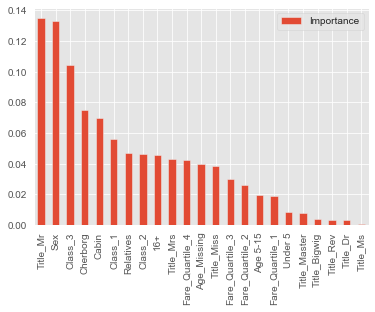

In [26]:
rf_clf = RandomForestClassifier()
rf_clf.fit(features,target)
pred = rf_clf.predict(features)

display(round(accuracy_score(target,pred),2))
print(classification_report(target,pred))
cm = confusion_matrix(target,pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,colorbar=True)
plt.show()

feature_importances = pd.DataFrame({'Importance':rf_clf.feature_importances_},index=features.columns)
display(_ = feature_importances.sort_values('Importance',ascending=False).plot(kind='bar'))

In [27]:
#Now optimise the random forest

params = {'bootstrap': [True, False],
 'max_depth': [1,3,5,7,10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,100]}

tuned_rf = GridSearchCV(rf_clf,param_grid = params,cv=5,scoring='accuracy',n_jobs=-1)
tuned_rf.fit(features,target)
print(tuned_rf.score(features, target))
print(tuned_rf.best_params_)

0.9988776655443322
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


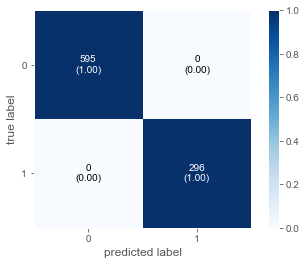

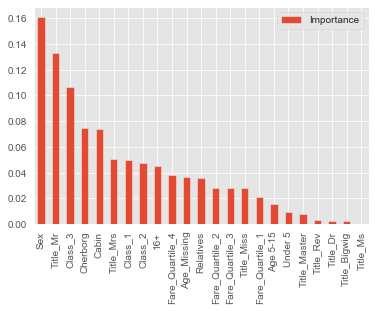

In [28]:
rf_opt = RandomForestClassifier(**tuned_rf.best_params_)
rf_opt.fit(features,target)
target = rf_opt.predict(features)
cm = confusion_matrix(target,pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,colorbar=True)
plt.show()

feature_importances = pd.DataFrame({'Importance':rf_opt.feature_importances_},index=features.columns)
display(_ = feature_importances.sort_values('Importance',ascending=False).plot(kind='bar'))

In [29]:
#Use unoptimised random forest on test set - this looks to be heavily overfitting
output = rf_opt.predict(titan_test.drop(['PassengerId'],axis=1))
submission = pd.DataFrame({'PassengerId':titan_test['PassengerId'],'Survived':output})
display(submission.head())
submission.to_csv('submission.csv',index=False)

ValueError: could not convert string to float: 'Kelly, Mr. James'